<a href="https://colab.research.google.com/github/ulya1202/NLP/blob/main/Date_try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from datetime import date



MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]


def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()


    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]


    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

np.random.seed(42)


n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [ ]:
size=100_000
X, y=random_dates(size)

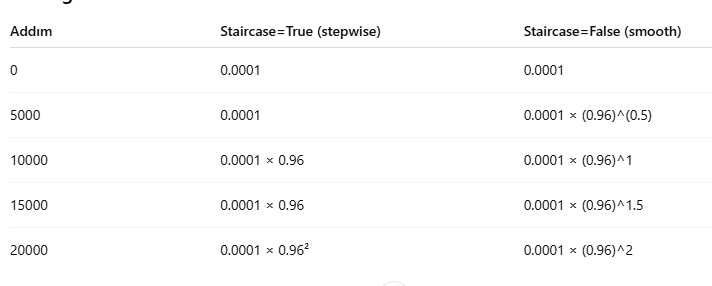

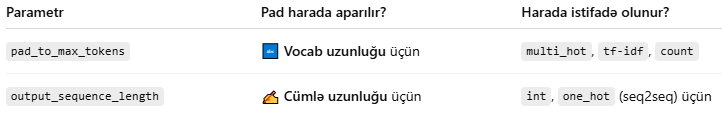

# Start

In [ ]:
#input
encoder_input=X
decoder_input=[f'startofseq {s}' for s in y]
#target
decoder_output=[f'{s} endofseq' for s in y]

In [ ]:
#Tokenization
max_input_sentence_len=max(len(sentence) for sentence in X)
max_output_date_len=max(len(f'startofseq {sentence} endofseq') for sentence in y)

encoder_vectorization_layer=tf.keras.layers.TextVectorization(output_mode='int',
                                                              output_sequence_length=max_input_sentence_len, #[1,2,3,0,0,0] cumlede sozleri tamamlayir 0 ile
                                                              split="character",
                                                              standardize='lower',

                                                              )
decoder_vectorization_layer=tf.keras.layers.TextVectorization(output_mode='int',
                                                              output_sequence_length=max_output_date_len,
                                                              split="character",
                                                              standardize='lower',

                                                              )

encoder_vectorization_layer.adapt(tf.constant(X))
decoder_vectorization_layer.adapt(tf.constant(decoder_input+decoder_output))


##train/test/val

In [ ]:
###################train
#>input
encoder_train_input=encoder_input[:int(len(X)*0.8)]
decoder_train_input=decoder_input[:int(len(X)*0.8)]

#>target
decoder_train_output=decoder_output[:int(len(X)*0.8)]

#################val
#>input
encoder_val_input=encoder_input[int(len(X)*0.8):]
decoder_val_input=decoder_input[int(len(X)*0.8):]

#>target
decoder_val_output=decoder_output[int(len(X)*0.8):]

###############change them to--> tensor#############
input_encoder_train=tf.constant(encoder_train_input)
input_decoder_train=tf.constant(decoder_train_input)
target_decoder_train=decoder_vectorization_layer(decoder_train_output)

input_encoder_val=tf.constant(encoder_val_input)
input_decoder_val=tf.constant(decoder_val_input)
target_decoder_val=decoder_vectorization_layer(decoder_val_output)


In [ ]:
encoder_vocab_size,decoder_vocab_size=(len(encoder_vectorization_layer.get_vocabulary()),len(decoder_vectorization_layer.get_vocabulary()))

In [ ]:
#Embedding
embed_size=16
encoder_embeding_layer=tf.keras.layers.Embedding(input_dim=encoder_vocab_size,
                                           output_dim=embed_size,
                                           mask_zero=True #cumlede tamamladiqimiz sozlerdeki 0l ari mask edir , fikir vermesin
                                           )
decoder_embeding_layer=tf.keras.layers.Embedding(input_dim=decoder_vocab_size,
                                           output_dim=embed_size,
                                           mask_zero=True #cumlede tamamladiqimiz sozlerdeki 0 lari mask edir , fikir vermesin
                                           )

In [ ]:
#(model)-->input-->tokenization-->embeding
input_encoder = tf.keras.layers.Input(shape=[],dtype=tf.string)
input_decoder = tf.keras.layers.Input(shape=[],dtype=tf.string)


encoder_tokens = encoder_vectorization_layer(input_encoder)
decoder_tokens = decoder_vectorization_layer(input_decoder)

encoder_embedding = encoder_embeding_layer(encoder_tokens)
decoder_embedding = decoder_embeding_layer(decoder_tokens)


In [ ]:
#(model)-->ENCODER(LSTM)--->encoder_output,*encoder_states
encoder_layer=tf.keras.layers.LSTM(512, return_state=True)
encoder_output, *encoder_state=encoder_layer(encoder_embedding)



In [ ]:
#(model)-->Decdoer(LSTM-->decoder_output,
decoder_layer=tf.keras.layers.LSTM(512,return_sequences=True,return_state=True)#return_state=True,
decoder_output, *decoder_state=decoder_layer(decoder_embedding, initial_state=encoder_state)

output_layer=tf.keras.layers.Dense(decoder_vocab_size, activation='softmax')
output=output_layer(decoder_output)


In [ ]:
my_date_model=tf.keras.Model(inputs=(input_encoder, input_decoder), outputs=output)

## Checkpoints and learnig rates

In [ ]:
model_chkp=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/date.keras',
                                   monitor="val_loss",
                                   save_best_only=True)


In [ ]:
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=200,
    decay_rate=0.96,
    staircase=False,
    name='ExponentialDecay')

## Compile and Fit

In [ ]:
optimizer=tf.optimizers.Nadam(learning_rate=0.0001)

In [ ]:
my_date_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=my_date_model.fit((input_encoder_train,input_decoder_train),target_decoder_train,
                          validation_data=((input_encoder_val,input_decoder_val),target_decoder_val),
                          epochs=1,callbacks=[model_chkp])

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9949 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 1.0555e-04


In [ ]:
# 
my_date_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/date.keras')

## Test

In [ ]:
def test(x,n):
    translate=''
    for i in range(n):
        input_encoder=tf.constant([x])
        input_decoder=tf.constant(['startofseq '+translate])

        y_proba=my_date_model.predict((input_encoder,input_decoder))[0,i] #bu
        idx=np.argmax(y_proba)
        predicted=decoder_vectorization_layer.get_vocabulary()[idx]

        if predicted==' ':
            break
        translate+=predicted
    return translate




In [ ]:
test('december 11, 9999',100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'9999-12-11'